In [1]:
import sys
import tensorflow as tf
import random
import numpy as np

import math
from uncertainties import ufloat
from uncertainties.umath import *

In [2]:
try:
    tf.reset_default_graph()
except AttributeError:
    tf.compat.v1.reset_default_graph()
    tf.compat.v1.disable_eager_execution()

In [3]:
def in_ipynb():
    try:
        cfg = get_ipython().config
        print(cfg)
        if 'jupyter' in cfg['IPKernelApp']['connection_file']:
            return True
        else:
            return False
    except NameError:
        return False

In [4]:
if in_ipynb():
    print("In IPython")
    TrainConfig="PFElectronConfig_EB_reclus_pteta_test"
    exec("import "+TrainConfig+" as Conf")
else:
    TrainConfig=sys.argv[1]
    print("Importing settings from "+ TrainConfig.replace("/", "."))
    #exec("from "+TrainConfig+" import *")
    importConfig=TrainConfig.replace("/", ".")
    exec("import "+importConfig+" as Conf")

{'IPKernelApp': {'connection_file': '/home/akapoor/.local/share/jupyter/runtime/kernel-6b3e2711-3159-4aa2-9f71-4ff9ab41e29b.json'}}
In IPython


In [5]:
if not hasattr(Conf, 'MVAlogplot'): Conf.MVAlogplot=False
if not hasattr(Conf, 'Multicore'): Conf.Multicore=False
if not hasattr(Conf, 'RandomState'): Conf.RandomState=42
if not hasattr(Conf, 'flatten'): Conf.flatten=False
if not hasattr(Conf, 'testsize'): Conf.testsize=0.2
if not hasattr(Conf, 'Debug'): Conf.Debug=False

In [6]:
tf.compat.v1.random.set_random_seed(Conf.RandomState)
random.seed(Conf.RandomState)
np.random.seed(Conf.RandomState)

In [7]:
import os
os.system("")
try:
  import uproot3 as uproot
except ImportError:
  import uproot

In [8]:
import glob
import pandas as pd
import numpy as np
#import ROOT
import matplotlib.pyplot as plt
import json

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout

In [9]:
from Tools.PlotTools import *
import Tools.ptetaRwt as ptetaRwt

In [10]:
if len(Conf.Classes)>2:
    prGreen('You are running a multi-class classification: This is an experimental feature! Only ROCs, MVAs, models will saved. No thresholds available!')

if Conf.Debug==True:
    prGreen("Running in debug mode : Only every 10th event will be used")

if len(Conf.MVAs)>0:
    for MVAd in Conf.MVAs:
        os.system("mkdir -p " + Conf.OutputDirName+"/"+MVAd["MVAtype"])
prGreen("Making output directory")
os.system("mkdir -p " + Conf.OutputDirName)
os.system("mkdir -p " + Conf.OutputDirName+"/CodeANDConfig")
os.system("mkdir -p " + Conf.OutputDirName+"/Thresholds")
os.system("cp "+TrainConfig+".py ./"+ Conf.OutputDirName+"/CodeANDConfig/")
os.system("cp Trainer.py ./"+ Conf.OutputDirName+"/CodeANDConfig/")

 You are running a multi-class classification: This is an experimental feature! Only ROCs, MVAs, models will saved. No thresholds available!
 Running in debug mode : Only every 10th event will be used
 Making output directory


0

In [11]:
cat='Category'
weight='NewWt'
label=Conf.Classes

In [12]:
import Tools.readData as readData
import sys
import os

In [13]:
import pandas as pd
if Conf.loadfromsaved:
    df_final=pd.read_parquet(Conf.OutputDirName+'/df.parquet.gzip')
else:
    df_final=readData.daskframe_from_rootfiles(Conf.processes,Conf.Tree,branches=Conf.branches,flatten=Conf.flatten,debug=Conf.Debug)
    if hasattr(Conf, 'SaveDataFrameCSV'):
        if Conf.SaveDataFrameCSV:
            prGreen("Saving DataFrame : It can take sometime")
            df_final.to_parquet(Conf.OutputDirName+'/df.parquet.gzip',compression='gzip')

Creating dask graph!
Testing single file first
/scratch/PFNtuples_July_correct/mc/DYJets_incl_MLL-50_TuneCP5_14TeV-madgraphMLM-pythia8/crab_DYJets_incl_MLL-50_TuneCP5_14TeV-madgraphMLM-pythia8_July2021newflaaddedclusterisog_ondisknow/210711_205559/0000/output_1.root
Finally, getting data from
/scratch/PFNtuples_July_correct/mc/QCD_Pt_80to170_bcToE_TuneCP5_13TeV_pythia8/crab_QCD_Pt_80to170_bcToE_TuneCP5_13TeV_pythia8_July2021newflaaddedclusterisog/210711_210521/0000/output_4.root
/scratch/PFNtuples_July_correct/mc/TauGun_Pt-15to500_14TeV-pythia8/crab_TauGun_Pt-15to500_14TeV-pythia8_July2021newflaaddedclusterisog/210711_205615/0000/output_2.root
/scratch/PFNtuples_July_correct/mc/QCD_Pt_30to80_bcToE_TuneCP5_13TeV_pythia8/crab_QCD_Pt_30to80_bcToE_TuneCP5_13TeV_pythia8_July2021newflaaddedclusterisog/210711_210515/0000/output_2.root
/scratch/PFNtuples_July_correct/mc/QCD_Pt_170to250_bcToE_TuneCP5_13TeV_pythia8/crab_QCD_Pt_170to250_bcToE_TuneCP5_13TeV_pythia8_July2021newflaaddedclusterisog/2

/scratch/PFNtuples_July_correct/mc/QCD_Pt_170to250_bcToE_TuneCP5_13TeV_pythia8/crab_QCD_Pt_170to250_bcToE_TuneCP5_13TeV_pythia8_July2021newflaaddedclusterisog/210711_210457/0000/output_8.root
/scratch/PFNtuples_July_correct/mc/GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCP5_14TeV_Pythia8/crab_GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCP5_14TeV_Pythia8_July2021newflaaddedclusterisog/210711_205621/0000/output_12.root
/scratch/PFNtuples_July_correct/mc/QCD_Pt_80to170_bcToE_TuneCP5_13TeV_pythia8/crab_QCD_Pt_80to170_bcToE_TuneCP5_13TeV_pythia8_July2021newflaaddedclusterisog/210711_210521/0000/output_19.root
/scratch/PFNtuples_July_correct/mc/QCD_Pt_15to20_bcToE_TuneCP5_13TeV_pythia8/crab_QCD_Pt_15to20_bcToE_TuneCP5_13TeV_pythia8_July2021newflaaddedclusterisog/210711_210451/0000/output_5.root
/scratch/PFNtuples_July_correct/mc/GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCP5_14TeV_Pythia8/crab_GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCP5_14TeV_Pythia8_July2021newflaaddedc

/scratch/PFNtuples_July_correct/mc/GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCP5_14TeV_Pythia8/crab_GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCP5_14TeV_Pythia8_July2021newflaaddedclusterisog/210711_205621/0000/output_20.root
/scratch/PFNtuples_July_correct/mc/QCD_Pt_170to250_bcToE_TuneCP5_13TeV_pythia8/crab_QCD_Pt_170to250_bcToE_TuneCP5_13TeV_pythia8_July2021newflaaddedclusterisog/210711_210457/0000/output_2.root
/scratch/PFNtuples_July_correct/mc/QCD_Pt_30to80_bcToE_TuneCP5_13TeV_pythia8/crab_QCD_Pt_30to80_bcToE_TuneCP5_13TeV_pythia8_July2021newflaaddedclusterisog/210711_210515/0000/output_1.root
/scratch/PFNtuples_July_correct/mc/GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCP5_14TeV_Pythia8/crab_GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCP5_14TeV_Pythia8_July2021newflaaddedclusterisog/210711_205621/0000/output_2.root
/scratch/PFNtuples_July_correct/mc/QCD_Pt_80to170_bcToE_TuneCP5_13TeV_pythia8/crab_QCD_Pt_80to170_bcToE_TuneCP5_13TeV_pythia8_July2021newflaaddedcl

/scratch/PFNtuples_July_correct/mc/QCD_Pt_30to80_bcToE_TuneCP5_13TeV_pythia8/crab_QCD_Pt_30to80_bcToE_TuneCP5_13TeV_pythia8_July2021newflaaddedclusterisog/210711_210515/0000/output_16.root
/scratch/PFNtuples_July_correct/mc/QCD_Pt_250toInf_bcToE_TuneCP5_13TeV_pythia8/crab_QCD_Pt_250toInf_bcToE_TuneCP5_13TeV_pythia8_July2021newflaaddedclusterisog/210711_210509/0000/output_7.root
/scratch/PFNtuples_July_correct/mc/DYToEE_M-50_NNPDF31_TuneCP5_14TeV-powheg-pythia8/crab_DYToEE_M-50_NNPDF31_TuneCP5_14TeV-powheg-pythia8_July2021newflaaddedclusterisog/210711_205609/0000/output_5.root
/scratch/PFNtuples_July_correct/mc/QCD_Pt_170to250_bcToE_TuneCP5_13TeV_pythia8/crab_QCD_Pt_170to250_bcToE_TuneCP5_13TeV_pythia8_July2021newflaaddedclusterisog/210711_210457/0000/output_10.root
/scratch/PFNtuples_July_correct/mc/QCD_Pt_250toInf_bcToE_TuneCP5_13TeV_pythia8/crab_QCD_Pt_250toInf_bcToE_TuneCP5_13TeV_pythia8_July2021newflaaddedclusterisog/210711_210509/0000/output_4.root
/scratch/PFNtuples_July_correct/

In [14]:
df_final[cat]=0
for i,k in enumerate(Conf.Classes):
    df_final.loc[df_final.Class == k, cat] = i

In [15]:
import inspect
if (hasattr(Conf, 'modifydf') and inspect.isfunction(Conf.modfiydf)):
    Conf.modfiydf(df_final)

In [16]:
index = df_final.index
Classes=Conf.Classes

In [17]:
from sklearn.model_selection import train_test_split

TrainIndices=[]
TestIndices=[]


In [18]:
for myclass in Classes:
    condition = df_final["Class"] == myclass
    Indices = index[condition].values.tolist()
    myclassTrainIndices, myclassTestIndices = train_test_split(Indices, test_size=Conf.testsize, random_state=Conf.RandomState, shuffle=True)
    TrainIndices=TrainIndices + myclassTrainIndices
    TestIndices=TestIndices + myclassTestIndices

In [19]:
df_final.loc[TrainIndices,'Dataset'] = "Train"
df_final.loc[TestIndices,'Dataset'] = "Test"

df_final.loc[TrainIndices,'TrainDataset'] = 1
df_final.loc[TestIndices,'TrainDataset'] = 0

In [20]:
prGreen("Reading classes:")
print(df_final.Class.unique().tolist())

 Reading classes:
['IsolatedSignal', 'NonIsolatedSignal', 'NonIsolatedBackground', 'FromHadronicTaus', 'FromPhotons']


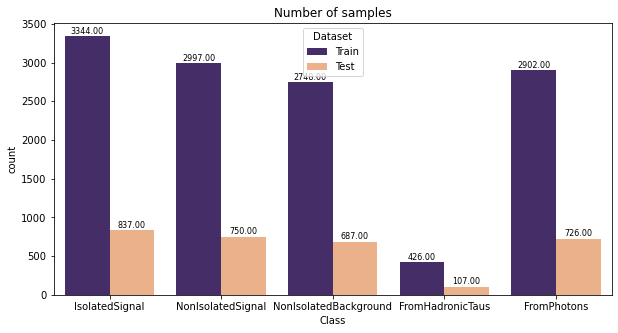

In [21]:
import seaborn as sns
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
kplot=sns.countplot(x="Class", data=df_final, ax=axes,hue='Dataset',palette=['#432371',"#FAAE7B","black"])
for p in kplot.patches:
    kplot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points',size=8)
axes.set_title("Number of samples")
#axes.set_yscale("log")
plt.savefig(Conf.OutputDirName+"/TotalStat_TrainANDTest.pdf")
plt.savefig(Conf.OutputDirName+"/TotalStat_TrainANDTest.png")

In [22]:
df_final[weight]=1

ReweightClass=Conf.WhichClassToReweightTo

print("After reweighting> In Training:")
if Conf.Reweighing=='True':
    df_final.loc[TrainIndices,weight]=ptetaRwt.df_pteta_rwt(df_final.loc[TrainIndices],"Class",
                                                   ptw=Conf.ptbins,etaw=Conf.etabins,
                                                   pt=Conf.ptwtvar,eta=Conf.etawtvar,
                                                   SumWeightCol='xsecwt',NewWeightCol=weight,
                                                   cand=ReweightClass,Classes=Conf.Classes)


# In[22]:


print("After reweighting> In Testing:")
if Conf.Reweighing=='True':
    df_final.loc[TestIndices,weight]=ptetaRwt.df_pteta_rwt(df_final.loc[TestIndices],"Class",
                                                  ptw=Conf.ptbins,etaw=Conf.etabins,
                                                  pt=Conf.ptwtvar,eta=Conf.etawtvar,
                                                  SumWeightCol='xsecwt',NewWeightCol=weight,
                                                  cand=ReweightClass,Classes=Conf.Classes)

After reweighting> In Training:
Number of events in IsolatedSignal after  weighing = 3344.0
Number of events in NonIsolatedSignal after  weighing = 3344.0
Number of events in NonIsolatedBackground after  weighing = 3344.0
Number of events in FromHadronicTaus after  weighing = 3344.0
Number of events in FromPhotons after  weighing = 3344.0
After reweighting> In Testing:
Number of events in IsolatedSignal after  weighing = 837.0
Number of events in NonIsolatedSignal after  weighing = 797.0
Number of events in NonIsolatedBackground after  weighing = 823.0000000000001
Number of events in FromHadronicTaus after  weighing = 579.0
Number of events in FromPhotons after  weighing = 836.0


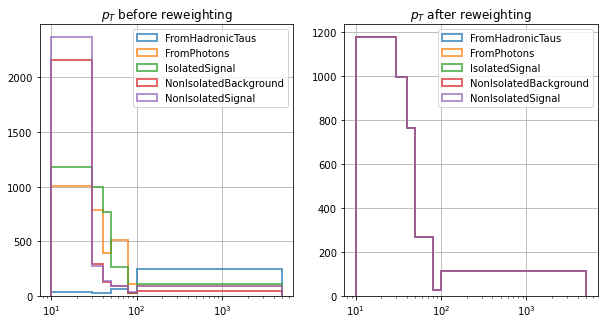

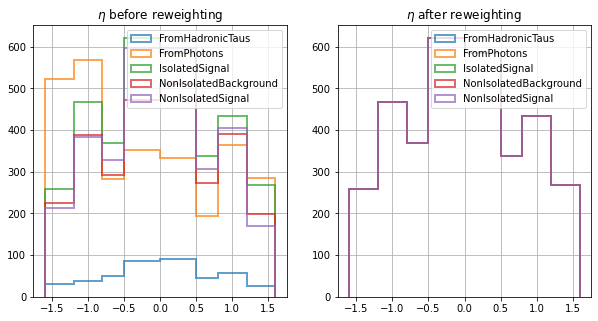

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i,group_df in df_final[df_final['Dataset'] == "Train"].groupby("Class"):
    group_df[Conf.ptwtvar].hist(histtype='step', bins=Conf.ptbins, alpha=0.7,label=i, ax=ax[0], density=False, ls='-', weights =group_df["xsecwt"],linewidth=2)
    ax[0].set_title("$p_T$ before reweighting")
    ax[0].legend()
    ax[0].set_xscale('log')
    group_df[Conf.ptwtvar].hist(histtype='step', bins=Conf.ptbins, alpha=0.7,label=i, ax=ax[1], density=False, ls='-', weights =group_df["NewWt"],linewidth=2)
    ax[1].set_title("$p_T$ after reweighting")
    ax[1].legend()
    ax[1].set_xscale('log')
fig.savefig(Conf.OutputDirName+"/pT_rwt.pdf")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i,group_df in df_final[df_final['Dataset'] == "Train"].groupby("Class"):
    group_df[Conf.etawtvar].hist(histtype='step',
                                 bins=Conf.etabins,
                                 #[i for i in range(len(Conf.etabins)-1)],
                                 alpha=0.7,label=i, ax=ax[0], density=False, ls='-', weights =group_df["xsecwt"],linewidth=2)
    ax[0].set_title("$\eta$ before reweighting")
    ax[0].legend()
    group_df[Conf.etawtvar].hist(histtype='step',
                                 bins=Conf.etabins,
                                 alpha=0.7,label=i, ax=ax[1], density=False, ls='-', weights =group_df["NewWt"],linewidth=2)
    ax[1].set_title("$\eta$ after reweighting")
    ax[1].legend()
fig.savefig(Conf.OutputDirName+"/eta_rwt.pdf")

In [24]:
def PrepDataset(df_final,TrainIndices,TestIndices,features,cat,weight):
    X_train = df_final.loc[TrainIndices,features]
    Y_train = df_final.loc[TrainIndices,cat]
    Wt_train = df_final.loc[TrainIndices,weight]

    X_test = df_final.loc[TestIndices,features]
    Y_test = df_final.loc[TestIndices,cat]
    Wt_test = df_final.loc[TestIndices,weight]
    return np.asarray(X_train), np.asarray(Y_train), np.asarray(Wt_train), np.asarray(X_test), np.asarray(Y_test), np.asarray(Wt_test)

In [25]:
import pickle
import multiprocessing

In [26]:
for MVA in Conf.MVAs:
    if 'XGB' in MVA["MVAtype"]:
        if len(Conf.Classes)>2:
            print(f"{MVA['MVAtype']}: Sorry, at the moment XGBoost implementation does not support more than two classes!")
            print(f"{MVA['MVAtype']}: If you really need multi-class classification, you can use a DNN")
            continue
        MakeFeaturePlots(df_final,MVA["features"],MVA["feature_bins"],Set="Train",MVA=MVA["MVAtype"],OutputDirName=Conf.OutputDirName,label=Conf.Classes)
        MakeFeaturePlots(df_final,MVA["features"],MVA["feature_bins"],Set="Test",MVA=MVA["MVAtype"],OutputDirName=Conf.OutputDirName,label=Conf.Classes)
        MakeFeaturePlotsComb(df_final,MVA["features"],MVA["feature_bins"],MVA=MVA["MVAtype"],OutputDirName=Conf.OutputDirName,label=Conf.Classes)
        X_train, Y_train, Wt_train, X_test, Y_test, Wt_test = PrepDataset(df_final,TrainIndices,TestIndices,MVA["features"],cat,weight)
        prGreen(MVA["MVAtype"]+" Applying "+MVA["Scaler"])
        exec("from sklearn.preprocessing import "+MVA["Scaler"])
        exec("sc = "+MVA["Scaler"]+"()")
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
        prGreen(MVA["MVAtype"]+" Training starting")
        import xgboost as xgb
        from sklearn.model_selection import cross_val_score, GridSearchCV
        xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=Conf.RandomState)
        #xgb_model.set_config(verbosity=2)
        prGreen("Performing XGB grid search")
        if Conf.Multicore:
            cv = GridSearchCV(xgb_model, MVA["XGBGridSearch"],
                              scoring='neg_log_loss',cv=3,verbose=1,n_jobs=multiprocessing.cpu_count())#multiprocessing.cpu_count())
        else:
            cv = GridSearchCV(xgb_model, MVA["XGBGridSearch"],
                              scoring='neg_log_loss',cv=3,verbose=1)
        search=cv.fit(X_train, Y_train, sample_weight=Wt_train,verbose=1)
        pickle.dump(cv, open(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"modelXGB.pkl", "wb"))
        #modelDNN.save(Conf.OutputDirName+"/"+MVA+"_"+"modelDNN.h5")
        prGreen("Expected neg log loss of XGB model = "+str((np.round(np.average(search.best_score_),3))*100)+'%')
        #prGreen("Expected accuracy of XGB model = "+str((np.average(search.best_score_))*100)+'%')
        prGreen("XGB Best Parameters")

        #json.dumps(search.best_params_)
        prGreen(str(search.best_params_))

        df_final.loc[TrainIndices,MVA["MVAtype"]+"_pred"]=cv.predict_proba(X_train)[:,1]
        df_final.loc[TestIndices,MVA["MVAtype"]+"_pred"]=cv.predict_proba(X_test)[:,1]

        prGreen("Plotting output response for XGB")
        fig, axes = plt.subplots(1, 1, figsize=(5, 5))
        plot_mva(df_final.query('TrainDataset==1'),MVA["MVAtype"]+"_pred",bins=50,cat="Class",Wt=weight,ax=axes,sample='train',ls='dashed',logscale=Conf.MVAlogplot,label=Conf.Classes)
        plot_mva(df_final.query('TrainDataset==0'),MVA["MVAtype"]+"_pred",bins=50,cat="Class",Wt=weight,ax=axes,sample='test',ls='dotted',logscale=Conf.MVAlogplot,label=Conf.Classes)
        plt.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"XGBMVA.pdf")
        plt.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"XGBMVA.png")

        prGreen("Plotting ROC for XGB")
        fig, axes = plt.subplots(1, 1, figsize=(5, 5))
        if len(Conf.Classes)<=2:
            plot_roc_curve(df_final.query('TrainDataset==1'),MVA["MVAtype"]+"_pred", tpr_threshold=0, ax=axes, color=None, linestyle='-', label=MVA["Label"]+' Training',cat=cat,Wt=weight)
            plot_roc_curve(df_final.query('TrainDataset==0'),MVA["MVAtype"]+"_pred", tpr_threshold=0, ax=axes, color=None, linestyle='--', label=MVA["Label"]+' Testing',cat=cat,Wt=weight)
            if len(Conf.OverlayWP)>0:
                for color,OverlayWpi in zip(Conf.OverlayWPColors,Conf.OverlayWP):
                    plot_single_roc_point(df_final.query('TrainDataset==0'), var=OverlayWpi, ax=axes, color=color, marker='o', markersize=6, label=OverlayWpi+" Test dataset", cat=cat,Wt=weight)
            axes.set_ylabel("Background efficiency")
            axes.set_xlabel("Signal efficiency")
            axes.set_title(MVA["MVAtype"])
            axes.text(1.05, 0.5, 'CMS EGamma ID-Trainer',
                      horizontalalignment='center',
                      verticalalignment='center',
                      rotation='vertical',
                      transform=axes.transAxes)
            plt.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"XGBROC.pdf")
            plt.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"XGBROC.png")

 MakingTrain dataset feature plots
 MakingTest dataset feature plots
 Making Combined dataset feature plots
(12417, 5)
 DNN_rechitandclusteriso_2drwt_withpteta Applying MinMaxScaler
 DNN fitting running
Setting early stopping
Train on 12417 samples, validate on 3107 samples
Epoch 1/1000
12417/12417 [==============================] - 0s 11us/sample - loss: 0.9027 - accuracy: 0.7516 - val_loss: 0.8959 - val_accuracy: 0.7354
Epoch 2/1000
12417/12417 [==============================] - 0s 4us/sample - loss: 0.8927 - accuracy: 0.7522 - val_loss: 0.8941 - val_accuracy: 0.7370
Epoch 3/1000
12417/12417 [==============================] - 0s 4us/sample - loss: 0.8938 - accuracy: 0.7503 - val_loss: 0.8932 - val_accuracy: 0.7380
Epoch 4/1000
 2000/12417 [===>..........................] - ETA: 0s - loss: 0.8695 - accuracy: 0.7480

/home/akapoor/miniconda3/envs/py39_tf2.4gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


12417/12417 [==============================] - 0s 4us/sample - loss: 0.8865 - accuracy: 0.7470 - val_loss: 0.8952 - val_accuracy: 0.7361
Epoch 5/1000
12417/12417 [==============================] - 0s 4us/sample - loss: 0.9001 - accuracy: 0.7509 - val_loss: 0.8971 - val_accuracy: 0.7348
Epoch 6/1000
12417/12417 [==============================] - 0s 4us/sample - loss: 0.8932 - accuracy: 0.7445 - val_loss: 0.8981 - val_accuracy: 0.7303
Epoch 7/1000
12417/12417 [==============================] - 0s 4us/sample - loss: 0.8915 - accuracy: 0.7431 - val_loss: 0.8965 - val_accuracy: 0.7399
Epoch 8/1000
12417/12417 [==============================] - 0s 4us/sample - loss: 0.8982 - accuracy: 0.7424 - val_loss: 0.8983 - val_accuracy: 0.7422
Epoch 9/1000
12417/12417 [==============================] - 0s 4us/sample - loss: 0.9006 - accuracy: 0.7544 - val_loss: 0.8942 - val_accuracy: 0.7428
Epoch 10/1000
12417/12417 [==============================] - 0s 4us/sample - loss: 0.9075 - accuracy: 0.7393 - va

/home/akapoor/miniconda3/envs/py39_tf2.4gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Assuming that first two classes are signal: To make any change, please change hardcoded discriminator


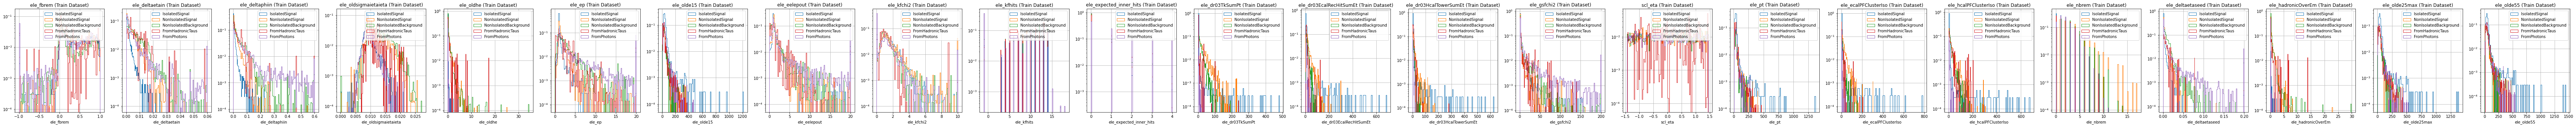

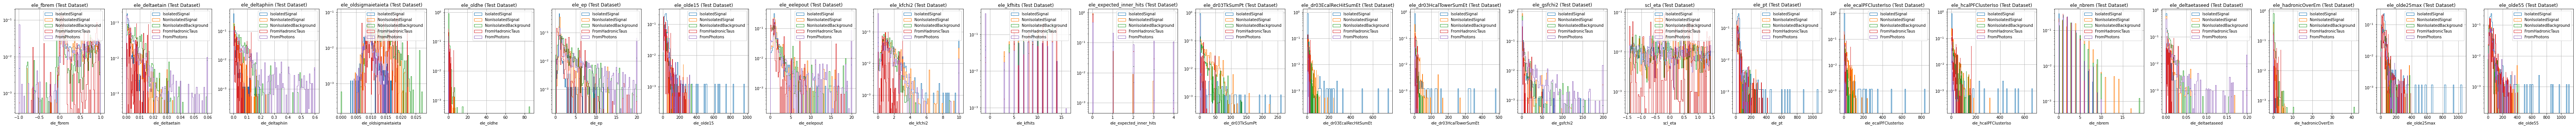

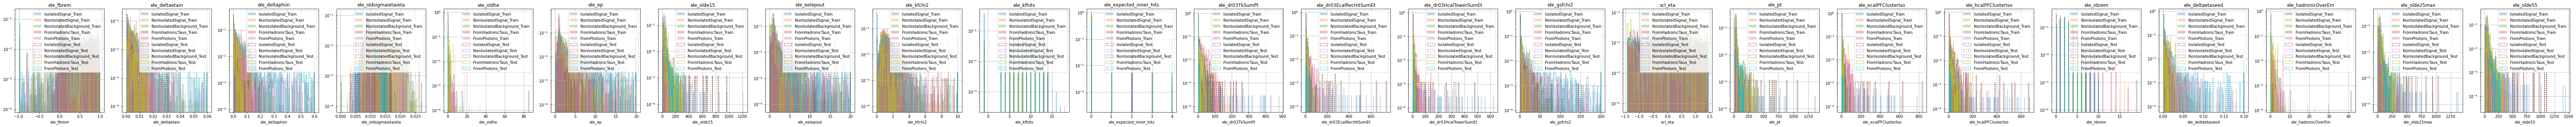

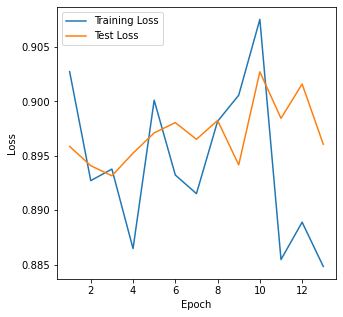

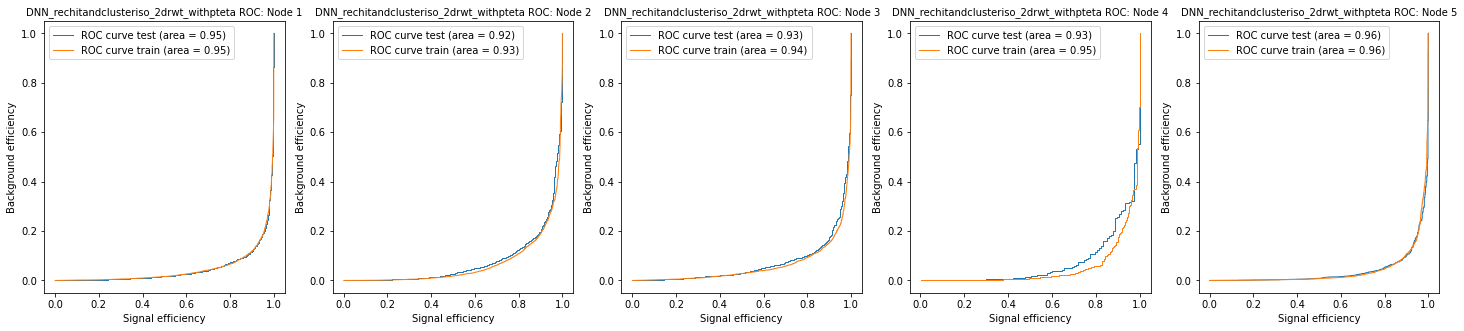

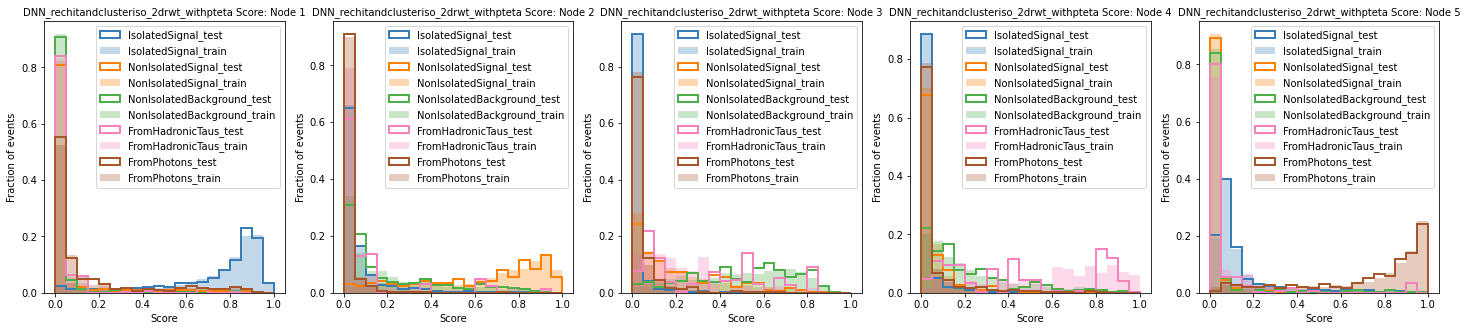

In [29]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
for MVA in Conf.MVAs:
    if 'DNN' in MVA["MVAtype"]:
        MakeFeaturePlots(df_final,MVA["features"],MVA["feature_bins"],Set="Train",MVA=MVA["MVAtype"],OutputDirName=Conf.OutputDirName,label=Conf.Classes)
        MakeFeaturePlots(df_final,MVA["features"],MVA["feature_bins"],Set="Test",MVA=MVA["MVAtype"],OutputDirName=Conf.OutputDirName,label=Conf.Classes)
        MakeFeaturePlotsComb(df_final,MVA["features"],MVA["feature_bins"],MVA=MVA["MVAtype"],OutputDirName=Conf.OutputDirName,label=Conf.Classes)
        X_train, Y_train, Wt_train, X_test, Y_test, Wt_test = PrepDataset(df_final,TrainIndices,TestIndices,MVA["features"],cat,weight)
        Y_train = to_categorical(Y_train, num_classes=len(Conf.Classes))
        Y_test = to_categorical(Y_test, num_classes=len(Conf.Classes))
        print(Y_train.shape)
        prGreen(MVA["MVAtype"]+" Applying "+MVA["Scaler"])
        exec("from sklearn.preprocessing import "+MVA["Scaler"])
        exec("sc = "+MVA["Scaler"]+"()")
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
        prGreen("DNN fitting running")

        #es=['']
        #if hasattr(Conf, 'MVA["DNNDict"]['earlyStopping']'):
        try:
            es = MVA["DNNDict"]['earlyStopping']
            print("Setting early stopping")
        except KeyError:
            es=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
            print("No early stopping specified, will use the default one")
        #es = MVA["DNNDict"]['earlyStopping']
        modelDNN=MVA["DNNDict"]['model']
        modelDNN.compile(loss=MVA["DNNDict"]['compile']['loss'], optimizer=MVA["DNNDict"]['compile']['optimizer'], metrics=MVA["DNNDict"]['compile']['metrics'])
        train_history = modelDNN.fit(X_train,Y_train,epochs=MVA["DNNDict"]['epochs'],batch_size=MVA["DNNDict"]['batchsize'],validation_data=(X_test,Y_test, Wt_test),
                                     verbose=1,callbacks=[es], sample_weight=Wt_train)
        modelDNN.save(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"modelDNN.h5")
        
        training_loss = train_history.history['loss']
        test_loss = train_history.history['val_loss']

        # Create count of the number of epochs
        epoch_count = range(1, len(training_loss) + 1)

        # Visualize loss history
        fig, axes = plt.subplots(1, 1, figsize=(5, 5))
        axes.plot(epoch_count, training_loss)
        axes.plot(epoch_count, test_loss)
        axes.legend(['Training Loss', 'Test Loss'])
        axes.set_xlabel('Epoch')
        axes.set_ylabel('Loss')
        plt.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"Loss.pdf")
        plt.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"Loss.png")
        
        y_train_pred=np.array(modelDNN.predict(X_train,batch_size=5000)) #This is not the training batch size
        y_test_pred=np.array(modelDNN.predict(X_test,batch_size=5000)) #This is not the training batch size
        #https://anshulhep.medium.com/make-your-tensorflow-keras-predictions-faster-with-batch-size-8bbd780b9c08

        from sklearn.metrics import roc_curve, auc

        n_classes=len(Conf.Classes)
        fig, axes = plt.subplots(1, n_classes, figsize=(n_classes*5, 5))
        figMVA, axesMVA = plt.subplots(1, n_classes, figsize=(n_classes*5, 5))

        for i in range(n_classes):
            axMVA=axesMVA[i]
            ax=axes[i]
            for k in range(n_classes):
                axMVA.hist(y_test_pred[:, i][Y_test[:, k]==1],bins=np.linspace(0, 1, 21),label=Conf.Classes[k]+'_test',
                           weights=Wt_test[Y_test[:, k]==1]/np.sum(Wt_test[Y_test[:, k]==1]),
                           histtype='step',linewidth=2,color=Conf.ClassColors[k])
                axMVA.hist(y_train_pred[:, i][Y_train[:, k]==1],bins=np.linspace(0, 1, 21),label=Conf.Classes[k]+'_train',
                           weights=Wt_train[Y_train[:, k]==1]/np.sum(Wt_train[Y_train[:, k]==1]),
                           histtype='stepfilled',alpha=0.3,linewidth=2,color=Conf.ClassColors[k])
            axMVA.set_title(MVA["MVAtype"]+' Score: Node '+str(i+1),fontsize=10)
            axMVA.set_xlabel('Score',fontsize=10)
            axMVA.set_ylabel('Fraction of events',fontsize=10)
            axMVA.legend(loc="upper right",fontsize=10)
            if Conf.MVAlogplot:
                axMVA.set_xscale('log')

            fpr, tpr, th = roc_curve(Y_test[:, i], y_test_pred[:, i])
            fpr_tr, tpr_tr, th_tr = roc_curve(Y_train[:, i], y_train_pred[:, i])
            mask = tpr > 0.0
            fpr, tpr = fpr[mask], tpr[mask]

            mask = tpr_tr > 0.0
            fpr_tr, tpr_tr = fpr_tr[mask], tpr_tr[mask]

            roc_auc = auc(fpr, tpr)
            roc_auc_tr = auc(fpr_tr, tpr_tr)
            
            ax.plot(tpr, fpr, label='ROC curve test (area = %0.2f)' % roc_auc,linewidth=1)
            ax.plot(tpr_tr, fpr_tr, label='ROC curve train (area = %0.2f)' % roc_auc_tr,linewidth=1)
            #plt.plot([0, 1], [0, 1], 'k--')
            #ax.set_xlim([0.8, 1.0])
            #ax.set_ylim([0.0, 1.05])
            ax.set_xlabel('Signal efficiency',fontsize=10)
            ax.set_ylabel('Background efficiency',fontsize=10)
            ax.set_title(MVA["MVAtype"]+' ROC: Node '+str(i+1),fontsize=10)
            ax.legend(loc="upper left",fontsize=10)
        fig.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"DNNROC.pdf")
        fig.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"DNNROC.png")
        figMVA.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"DNNMVA.pdf")
        figMVA.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"DNNMVA.png")

        if len(Conf.Classes)<=2:
            df_final.loc[TrainIndices,MVA["MVAtype"]+"_pred"]=modelDNN.predict(X_train,batch_size=5000)[:,1]
            df_final.loc[TestIndices,MVA["MVAtype"]+"_pred"]=modelDNN.predict(X_test,batch_size=5000)[:,1]


        if len(Conf.Classes)>2:
            print("Assuming that first two classes are signal: To make any change, please change hardcoded discriminator")
            df_final.loc[TrainIndices,MVA["MVAtype"]+"_pred"]=np.sum([modelDNN.predict(X_train,batch_size=5000)[:, 0],modelDNN.predict(X_train,batch_size=5000)[:, 1]],axis=0)
            df_final.loc[TestIndices,MVA["MVAtype"]+"_pred"]=np.sum([modelDNN.predict(X_test,batch_size=5000)[:, 0],modelDNN.predict(X_test,batch_size=5000)[:, 1]],axis=0)
            
            

In [ ]:
for MVA in Conf.MVAs:
    if 'Genetic' in MVA["MVAtype"]:
        prGreen("Sorry Genetic algo not implemented yet! Coming Soon")

In [ ]:
if len(Conf.Classes)<=2:
    prGreen("Plotting Final ROC")
    fig, axes = plt.subplots(1, 1, figsize=(5, 5))
    if len(Conf.OverlayWP)>0:
        for color,OverlayWpi in zip(Conf.OverlayWPColors,Conf.OverlayWP):
            plot_single_roc_point(df_final.query('TrainDataset==0'), var=OverlayWpi, ax=axes, color=color, marker='o', markersize=8, label=OverlayWpi+" Test dataset", cat=cat,Wt=weight)
    if len(Conf.MVAs)>0:
        for MVAi in Conf.MVAs:
            plot_roc_curve(df_final.query('TrainDataset==0'),MVAi["MVAtype"]+"_pred", tpr_threshold=0.7, ax=axes, color=MVAi["Color"], linestyle='--', label=MVAi["Label"]+' Testing',cat=cat,Wt=weight)
            plot_roc_curve(df_final.query('TrainDataset==1'),MVAi["MVAtype"]+"_pred", tpr_threshold=0.7, ax=axes, color=MVAi["Color"], linestyle='-', label=MVAi["Label"]+' Training',cat=cat,Wt=weight)
        axes.set_ylabel("Background efficiency")
        axes.set_xlabel("Signal efficiency")
        axes.set_title("Final")
        axes.text(1.05, 0.5, 'CMS EGamma ID-Trainer',
                  horizontalalignment='center',
                  verticalalignment='center',
                  rotation='vertical',
                  transform=axes.transAxes)
    plt.savefig(Conf.OutputDirName+"/ROCFinal.pdf")
    plt.savefig(Conf.OutputDirName+"/ROCFinal.png")

In [ ]:
def eff(group_df,var,cat,catvalue):
    signalpass=len(group_df.query('('+var+' == 1) & ('+cat+' == '+str(catvalue)+')'))
    signalpass=ufloat(signalpass,math.sqrt(signalpass))
    signaltotal=len(group_df.query('('+cat+' == '+str(catvalue)+')'))
    signaltoal=ufloat(signaltotal,math.sqrt(signaltotal))
    if signaltotal>0:
        signaleff=(100*signalpass)/(signaltotal)
        return [signaleff.n, signaleff.s]
    else:
        print("Some bins have zero signal: assigning zero eff")
        return [0, 0]

def EffTrend(cat='',var='',groupbyvar='',ptbins=[],label='',title='',plotname='',df=pd.DataFrame(),plot_dir='',Classes=[''],Colors=['']):
    figMVAComp, axesComp = plt.subplots(1,1, figsize=(6, 6))
    ax=axesComp
    fulllist=[[] for i in range(len(Classes))]
    fullliste=[[[] for i in range(2)] for i in range(len(Classes))]
    ptbinsmy=ptbins[:-1]
    for i,group_df in df.groupby(groupbyvar):
        for k in range(len(Classes)):
            val=eff(group_df,var,cat,k)[0]
            vale=eff(group_df,var,cat,k)[1]
            fulllist[k].append(val)
            fullliste[k][0].append(vale)
            if val+vale<100:
                fullliste[k][1].append(vale)
            else:
                fullliste[k][1].append(100-val)
                
        
    for m in range(len(Classes)):
        if m==0 or m==1:
            marker='$S$'
        else:
            marker='$B$'
        ax.errorbar(ptbinsmy,fulllist[m],yerr=fullliste[m],markersize=8,marker=marker,markeredgecolor='black',label=Classes[m],color=Colors[m])
    ax.set_ylim(0,130)
    if groupbyvar=='ele_pt_bin':
        ax.set_xlim(0)
    ax.set_xlabel(label)
    ax.set_ylabel("Efficiency (%)")
    ax.set_title(title)
    ax.grid(True)
    #ax.legend(loc='best',ncol=2,bbox_to_anchor=(0., 1.1, 1., 0.2),fontsize=8)
    ax.legend(loc='best',ncol=2,fontsize=10)
    figMVAComp.savefig(plot_dir+plotname)

In [ ]:
PredMVAs=[]
for MVA in Conf.MVAs:
    PredMVAs.append(MVA["MVAtype"]+'_pred')
SigEffWPs=Conf.SigEffWPs[:]
for i,SigEffWPi in enumerate(SigEffWPs):
    SigEffWPs[i]=1-(int(SigEffWPi.replace('%', ''))/100)
    

for MVA in Conf.MVAs:

        df_final["ele_pt_bin"] = pd.cut(df_final[Conf.ptwtvar], bins=Conf.ptbins, labels=list(range(len(Conf.ptbins)-1)))
        df_final["ele_eta_bin"] = pd.cut(df_final[Conf.etawtvar], bins=Conf.etabins, labels=list(range(len(Conf.etabins)-1)))

        EB_train=df_final.loc[TrainIndices]
        EB_test=df_final.loc[TestIndices]

        if len(Conf.Classes) > 2:
            print("Assuming that first two classes are signal: To make any change, please change hardcoded discriminator")
            mydftrain=EB_train.query(cat+"==1 | "+cat+"==0")[[MVA["MVAtype"]+"_pred"]].quantile(SigEffWPs)
            mydftest=EB_test.query(cat+"==1 | "+cat+"==0")[[MVA["MVAtype"]+"_pred"]].quantile(SigEffWPs)
        if len(Conf.Classes) < 3:
            print("Assuming that second class is signal: To make any change, please change hardcoded discriminator")
            mydftrain=EB_train.query(cat+"==1")[[MVA["MVAtype"]+"_pred"]].quantile(SigEffWPs)
            mydftest=EB_test.query(cat+"==1")[[MVA["MVAtype"]+"_pred"]].quantile(SigEffWPs)
            
        EB_train.loc[EB_train[MVA["MVAtype"]+"_pred"] > mydftrain.iat[0,0], MVA["MVAtype"]+"_predpass"] = 1
        EB_train.loc[EB_train[MVA["MVAtype"]+"_pred"] < mydftrain.iat[0,0], MVA["MVAtype"]+"_predpass"] = 0

        EB_train.loc[EB_train[MVA["MVAtype"]+"_pred"] > mydftrain.iat[1,0], MVA["MVAtype"]+"_predpass1"] = 1
        EB_train.loc[EB_train[MVA["MVAtype"]+"_pred"] < mydftrain.iat[1,0], MVA["MVAtype"]+"_predpass1"] = 0

        EB_test.loc[EB_test[MVA["MVAtype"]+"_pred"] > mydftest.iat[0,0], MVA["MVAtype"]+"_predpass"] = 1
        EB_test.loc[EB_test[MVA["MVAtype"]+"_pred"] < mydftest.iat[0,0], MVA["MVAtype"]+"_predpass"] = 0

        EB_test.loc[EB_test[MVA["MVAtype"]+"_pred"] > mydftest.iat[1,0], MVA["MVAtype"]+"_predpass1"] = 1
        EB_test.loc[EB_test[MVA["MVAtype"]+"_pred"] < mydftest.iat[1,0], MVA["MVAtype"]+"_predpass1"] = 0

        variables=['ele_pt_bin','ele_eta_bin']
        bins=[Conf.ptbins,Conf.etabins]
        xaxislabels=['$p_T$ (GeV)','$\eta$']
        Wps=Conf.OverlayWP

        for variable,xaxislabel,binn in zip(variables,xaxislabels,bins):
            EffTrend(cat=cat,var=MVA["MVAtype"]+"_predpass",groupbyvar=variable,ptbins=binn,label=xaxislabel,title=f"At {Conf.SigEffWPs[0]} overall signal efficiency",plotname="New_MultiClass_ID_Val_"+Conf.SigEffWPs[0]+"_"+variable+"="+str(mydftrain.iat[0,0])+".pdf",df=EB_train,plot_dir=Conf.OutputDirName+"/"+MVA["MVAtype"]+"/Train_",Classes=Conf.Classes,Colors=Conf.ClassColors)
            EffTrend(cat=cat,var=MVA["MVAtype"]+"_predpass1",groupbyvar=variable,ptbins=binn,label=xaxislabel,title=f"At {Conf.SigEffWPs[1]} overall signal efficiency",plotname="New_MultiClass_ID_Val_"+Conf.SigEffWPs[1]+"_"+variable+"="+str(mydftrain.iat[1,0])+".pdf",df=EB_train,plot_dir=Conf.OutputDirName+"/"+MVA["MVAtype"]+"/Train_",Classes=Conf.Classes,Colors=Conf.ClassColors)
            for Wp in Wps:
                EffTrend(cat=cat,var=Wp,groupbyvar=variable,ptbins=binn, label=xaxislabel,title='CMSSW_ID_'+Wp,plotname="CMSSW_ID_"+Wp+"_"+variable+"_.pdf",df=EB_train,plot_dir=Conf.OutputDirName+"/"+MVA["MVAtype"]+"/Train_",Classes=Conf.Classes,Colors=Conf.ClassColors)


            EffTrend(cat=cat,var=MVA["MVAtype"]+"_predpass",groupbyvar=variable,ptbins=binn,label=xaxislabel,title=f"At {Conf.SigEffWPs[0]} overall signal efficiency",plotname="New_MultiClass_ID_Val_"+Conf.SigEffWPs[0]+"_"+variable+"="+str(mydftest.iat[0,0])+".pdf",df=EB_test,plot_dir=Conf.OutputDirName+"/"+MVA["MVAtype"]+"/Test_",Classes=Conf.Classes,Colors=Conf.ClassColors)
            EffTrend(cat=cat,var=MVA["MVAtype"]+"_predpass1",groupbyvar=variable,ptbins=binn,label=xaxislabel,title=f"At {Conf.SigEffWPs[1]} overall signal efficiency",plotname="New_MultiClass_ID_Val_"+Conf.SigEffWPs[1]+"_"+variable+"="+str(mydftest.iat[1,0])+".pdf",df=EB_test,plot_dir=Conf.OutputDirName+"/"+MVA["MVAtype"]+"/Test_",Classes=Conf.Classes,Colors=Conf.ClassColors)
            for Wp in Wps:
                EffTrend(cat=cat,var=Wp,groupbyvar=variable,ptbins=binn, label=xaxislabel,title='CMSSW_ID_'+Wp,plotname="CMSSW_ID_"+Wp+"_"+variable+".pdf",df=EB_test,plot_dir=Conf.OutputDirName+"/"+MVA["MVAtype"]+"/Test_",Classes=Conf.Classes,Colors=Conf.ClassColors)

In [ ]:
prGreen("Threshold values for requested Signal Efficiencies (Train Dataset)")
if len(Conf.Classes)>2:
    mydf=df_final.query("TrainDataset==1 & ("+cat+"==1 | "+cat+"==0"+")")[PredMVAs].quantile(SigEffWPs)
if len(Conf.Classes)<=2:
    mydf=df_final.query("TrainDataset==1 & "+cat+"==1")[PredMVAs].quantile(SigEffWPs)
mydf.insert(0, "WPs", Conf.SigEffWPs, True)
mydf.set_index("WPs",inplace=True)
prGreen(mydf)
mydf.to_html(Conf.OutputDirName+'/Thresholds/'+"SigEffWPs_Train.html")
mydf.to_csv(Conf.OutputDirName+'/Thresholds/'+"SigEffWPs_Train.csv")
prGreen("Threshold values for requested Signal Efficiencies (Test Dataset)")
if len(Conf.Classes)>2:
    mydf2=df_final.query("TrainDataset==0 & ("+cat+"==1 | "+cat+"==0"+")")[PredMVAs].quantile(SigEffWPs)
if len(Conf.Classes)<=2:
    mydf2=df_final.query("TrainDataset==0 & "+cat+"==1")[PredMVAs].quantile(SigEffWPs)
mydf2.insert(0, "WPs", Conf.SigEffWPs, True)
mydf2.set_index("WPs",inplace=True)
prGreen(mydf2)
mydf2.to_html(Conf.OutputDirName+'/Thresholds/'+"SigEffWPs_Test.html")
mydf2.to_csv(Conf.OutputDirName+'/Thresholds/'+"SigEffWPs_Test.csv")

In [ ]:

pngtopdf(ListPattern=[Conf.OutputDirName+'/*/*ROC*png',Conf.OutputDirName+'/*ROC*png'],Save=Conf.OutputDirName+"/mydocROC.pdf")
pngtopdf(ListPattern=[Conf.OutputDirName+'/*/*MVA*png'],Save=Conf.OutputDirName+"/mydocMVA.pdf")

prGreen("Done!! Please find the quick look ROC pdf here "+Conf.OutputDirName+"/mydocROC.pdf")
prGreen("Done!! Please find the quick look MVA pdf here "+Conf.OutputDirName+"/mydocMVA.pdf")
prGreen("Individual plots and saved model files can be found in directory: "+Conf.OutputDirName+'/')